In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import exploration
import preprocess
import modeling
import evaluation
%matplotlib inline 
warnings.simplefilter('ignore')

C:\Users\yuwei\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
path = 'D:/UChicago/2019 spring/CAPP30254/assignments/HW3/projects_2012_2013.csv'
index_col = 'projectid'
project = exploration.read_data(path, index_col)
project.head()

,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_metro,school_district,school_county,...,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,date_posted,datefullyfunded
projectid,,,,,,,,,,,,,,,,,,,,,
00001ccc0e81598c4bd86bacb94d7acb,96963218e74e10c3764a5cfb153e6fea,9f3f9f2c2da7edda5648ccd10554ed8c,1.709930e+11,41.807654,-87.673257,Chicago,IL,urban,Pershing Elem Network,Cook,...,Visual Arts,Music & The Arts,Supplies,highest poverty,Grades PreK-2,1498.61,31.0,f,4/14/13,5/2/13
0000fa3aa8f6649abab23615b546016d,2a578595fe351e7fce057e048c409b18,3432ed3d4466fac2f2ead83ab354e333,6.409801e+10,34.296596,-119.296596,Ventura,CA,urban,Ventura Unif School District,Ventura,...,Literature & Writing,Literacy & Language,Books,highest poverty,Grades 3-5,282.47,28.0,t,4/7/12,4/18/12
000134f07d4b30140d63262c871748ff,26bd60377bdbffb53a644a16c5308e82,dc8dcb501c3b2bb0b10e9c6ee2cd8afd,6.227100e+10,34.078625,-118.257834,Los Angeles,CA,urban,Los Angeles Unif Sch Dist,Los Angeles,...,Social Sciences,History & Civics,Technology,high poverty,Grades 3-5,1012.38,56.0,f,1/30/12,4/15/12
0001f2d0b3827bba67cdbeaa248b832d,15d900805d9d716c051c671827109f45,8bea7e8c6e4279fca6276128db89292e,3.600090e+11,40.687286,-73.988217,Brooklyn,NY,urban,New York City Dept Of Ed,Kings (Brooklyn),...,NaN,NaN,Books,high poverty,Grades PreK-2,175.33,23.0,f,10/11/12,12/5/12
0004536db996ba697ca72c9e058bfe69,400f8b82bb0143f6a40b217a517fe311,fbdefab6fe41e12c55886c610c110753,3.606870e+11,40.793018,-73.205635,Central Islip,NY,suburban,Central Islip Union Free SD,Suffolk,...,Literature & Writing,Literacy & Language,Technology,high poverty,Grades PreK-2,3591.11,150.0,f,1/8/13,3/25/13


In [3]:
# Check which columns need imputation
print(project.isnull().any())

teacher_acctid                            False
schoolid                                  False
school_ncesid                              True
school_latitude                           False
school_longitude                          False
school_city                               False
school_state                              False
school_metro                               True
school_district                            True
school_county                             False
school_charter                            False
school_magnet                             False
teacher_prefix                            False
primary_focus_subject                      True
primary_focus_area                         True
secondary_focus_subject                    True
secondary_focus_area                       True
resource_type                              True
poverty_level                             False
grade_level                                True
total_price_including_optional_support  

# Create the outcome
If the project receive funding within 60 days, it will be labeled as 0, otherwise 1. 

In [4]:
period =  timedelta(days=60)
project = preprocess.create_outcome(project, 'date_posted', 'datefullyfunded', 'funded_interval', 'funded_outcome', period)

In [5]:
X = project.drop(columns=['datefullyfunded', 'funded_outcome'])
y = project[['funded_outcome']]

# Split the data
The rolling window is 6 months and delay interval is 60 days.

In [6]:
rolling = relativedelta(months=6)
start_date = pd.Timestamp(2012, 1, 1)
end_date = pd.Timestamp(2013, 12, 31)
delay_interval = timedelta(days=60)

In [7]:
split_results = modeling.split_data(X, y, 0.3, True, 'date_posted', start_date, end_date, delay_interval, rolling)

start date: 2012-01-01 00:00:00
train_end_date: 2012-05-01 00:00:00
test_start_date: 2012-07-01 00:00:00
test_end_date: 2012-12-31 00:00:00
end_date: 2013-12-31 00:00:00

start date: 2012-01-01 00:00:00
train_end_date: 2012-11-01 00:00:00
test_start_date: 2013-01-01 00:00:00
test_end_date: 2013-06-30 00:00:00
end_date: 2013-12-31 00:00:00

start date: 2012-01-01 00:00:00
train_end_date: 2013-05-01 00:00:00
test_start_date: 2013-07-01 00:00:00
test_end_date: 2013-12-31 00:00:00
end_date: 2013-12-31 00:00:00



# Data Preprocess & Modeling & Temporal Validation
We iterate through the split_results, for each pair of training and testing set, do the following things:
#### Preprocess and exploration
* Imputation: impute the categorical columns with 'unknown'; impute continuous columns with the mean of train data
* Discritization: based on the given label list, discritize the columns with corresponding percentiles of training data set and apply these bins to testing set. Here I choose "students_reached" and "total_price_including_optional_support" to create dummies and plot the distribution before discritization. It is obvious that there are some extreme values in those two columns
* Get dummies: for columns with more than k categories, only create the dummies for top k(k=20 here) categories (based on counts); for others,  get dummies of all the categories
* Drop columns: drop the id columns and categorical columns that have been hot encoding

#### Modeling
* run all the models in grid (you can choose to run large, small or test grid, here I use small gird)

#### Evaluation
* for each model, store its evaluation of baseline, accuarcy, auc_roc, f1, precision and recall at different levels
* store their precision_recall curve plots
* for decision tree and random forest models, print out their top 5 important feature

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC

model_list = ['Random Forest', 'Logistic Regression', 'Boosting', 'Decision Tree', 'Bagging']
clfs = {'Random Forest': RandomForestClassifier(n_estimators=50, n_jobs=-1),
        'Boosting': AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=200),
        'Logistic Regression': LogisticRegression(penalty='l1', C=1e5),
        #'Support Vector Machine': LinearSVC(kernel='linear', probability=True, random_state=0),
        'Decision Tree': DecisionTreeClassifier(),
        #'K Nearest Neighbors': KNeighborsClassifier(n_neighbors=3),
        'Bagging': BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=15, max_samples=0.5)}

large_grid = {'Random Forest':{'n_estimators': [1,10,100,1000,10000], 'max_depth': [1,5,10,20,50,100], 'min_samples_split': [2,5,10], 'n_jobs': [-1]},
              'Logistic Regression': { 'penalty': ['l1','l2'], 'C': [0.00001,0.0001,0.001,0.01,0.1,1,10]},
              'Extras Trees': { 'n_estimators': [1,10,100,1000,10000], 'criterion' : ['gini', 'entropy'] ,'max_depth': [1,5,10,20,50,100], 'max_features': ['sqrt','log2'],'min_samples_split': [2,5,10], 'n_jobs': [-1]},
              'Boosting': { 'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [1,10,100,1000,10000]},
              'Gradient boosting': {'n_estimators': [1,10,100,1000,10000], 'learning_rate' : [0.001,0.01,0.05,0.1,0.5],'subsample' : [0.1,0.5,1.0], 'max_depth': [1,3,5,10,20,50,100]},
              'Decision Tree': {'criterion': ['gini', 'entropy'], 'max_depth': [1,5,10,20,50,100], 'max_features': [None, 'sqrt','log2'],'min_samples_split': [2,5,10]},
    #'SVM' :{'C' :[0.00001,0.0001,0.001,0.01,0.1,1,10],'kernel':['linear']},
    #'KNN' :{'n_neighbors': [1,5,10,25,50,100],'weights': ['uniform','distance'],'algorithm': ['auto','ball_tree','kd_tree']}
           }

small_grid = {'Random Forest':{'n_estimators': [10, 100, 1000], 'max_depth': [5,50]},
              'Logistic Regression': { 'penalty': ['l1','l2'], 'C': [0.00001,0.001,0.1,1,10]},
              'Decision Tree': {'criterion': ['gini', 'entropy'], 'max_depth': [1,5,10,20,50,100],'min_samples_split': [2,5,10]},
              #'Support Vector Machine' :{'C' :[0.00001,0.0001,0.001,0.01,0.1,1,10],'kernel':['linear']},
              #'K Nearest Neighbors' :{'n_neighbors': [1,5,10,25,50,100],'weights': ['uniform','distance'],'algorithm': ['auto','ball_tree','kd_tree']}
              'Boosting':{'base_estimator':[LogisticRegression()], 'n_estimators':[10, 100, 1000], 'learning_rate':[1.0]},
              'Bagging':{'base_estimator':[DecisionTreeClassifier()], 'n_estimators':[10, 100, 1000], 'max_samples':[0.6, 0.3]},}
    
test_grid = {'Random Forest':{'n_estimators': [1], 'max_depth': [1]},
             'Logistic Regression': {'penalty': ['l1'], 'C': [0.01]},
             'Decision Tree': {'criterion': ['gini'], 'max_depth': [1],'min_samples_split': [10]},
             #'Support Vector Machine' :{'C' :[0.01],'kernel':['linear']},
             #'K Nearest Neighbors' :{'n_neighbors': [5],'weights': ['uniform'],'algorithm': ['auto']}
             'Boosting':{'base_estimator':[LogisticRegression()], 'n_estimators':[100], 'learning_rate':[1.0]},
             'Bagging':{'base_estimator':[DecisionTreeClassifier()], 'n_estimators':[100], 'max_samples':[0.6]},}

Lenth of training set: 21180; lenth of testing set: 32838


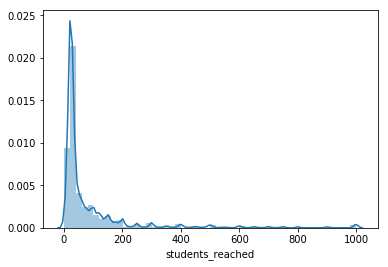

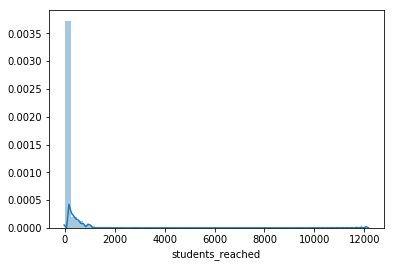

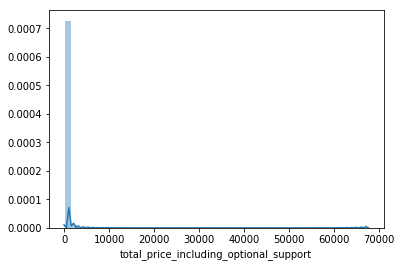

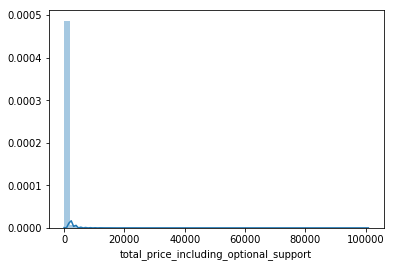

Running Random Forest ...
            Features  Importance
177   very_high_cost    0.147685
125                f    0.127273
178         low_cost    0.093622
163       Technology    0.076897
0    school_latitude    0.067073
Running Random Forest ...
            Features  Importance
178         low_cost    0.155081
177   very_high_cost    0.107686
125                f    0.102820
126                t    0.095980
0    school_latitude    0.078154
Running Random Forest ...
            Features  Importance
178         low_cost    0.167180
177   very_high_cost    0.120543
125                f    0.091601
126                t    0.090872
0    school_latitude    0.070859
Running Random Forest ...
             Features  Importance
1    school_longitude    0.120417
0     school_latitude    0.119279
178          low_cost    0.024805
182      midlle_sclae    0.020442
127              Mrs.    0.020051
Running Random Forest ...
             Features  Importance
1    school_longitude    0.121304
0   

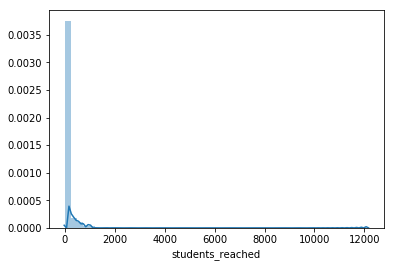

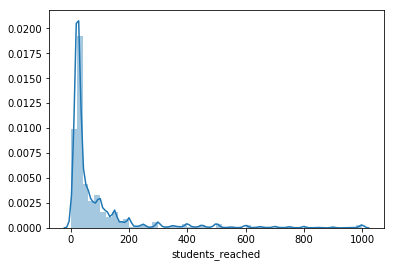

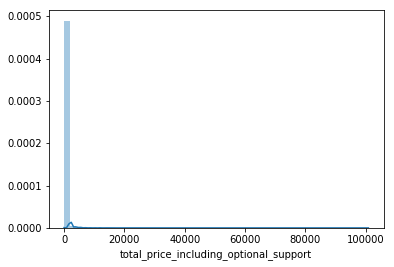

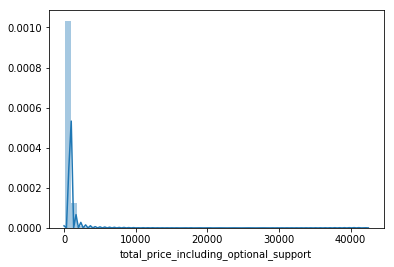

Running Random Forest ...
            Features  Importance
177         low_cost    0.305002
176   very_high_cost    0.211817
0    school_latitude    0.068465
125                t    0.056967
124                f    0.052691
Running Random Forest ...
           Features  Importance
177        low_cost    0.212253
176  very_high_cost    0.190071
163      Technology    0.069377
125               t    0.066945
124               f    0.060383
Running Random Forest ...
           Features  Importance
177        low_cost    0.220488
176  very_high_cost    0.153155
125               t    0.072083
124               f    0.070173
163      Technology    0.053673
Running Random Forest ...
             Features  Importance
0     school_latitude    0.126802
1    school_longitude    0.125896
177          low_cost    0.023291
176    very_high_cost    0.020464
181      midlle_sclae    0.019859
Running Random Forest ...
             Features  Importance
0     school_latitude    0.126352
1    school_long

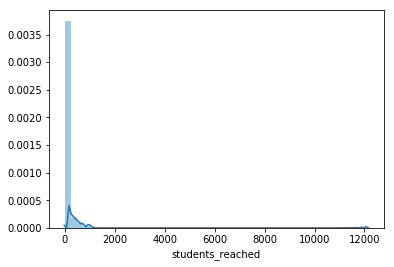

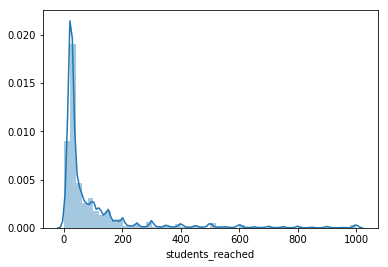

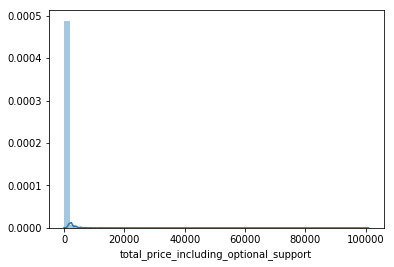

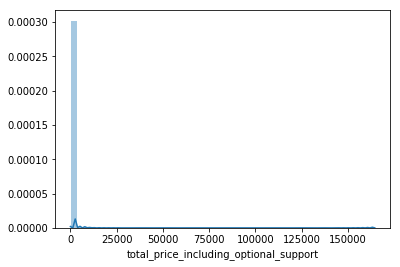

Running Random Forest ...
             Features  Importance
175          low_cost    0.341108
177    very_high_cost    0.198240
124                 f    0.068209
1    school_longitude    0.066889
125                 t    0.057713
Running Random Forest ...
            Features  Importance
175         low_cost    0.226756
177   very_high_cost    0.141458
124                f    0.110038
125                t    0.091479
0    school_latitude    0.058333
Running Random Forest ...
           Features  Importance
175        low_cost    0.219138
177  very_high_cost    0.167591
124               f    0.090861
125               t    0.082031
162      Technology    0.062860
Running Random Forest ...
             Features  Importance
0     school_latitude    0.133990
1    school_longitude    0.132020
175          low_cost    0.025234
172        Grades 3-5    0.019335
126              Mrs.    0.019072
Running Random Forest ...
             Features  Importance
0     school_latitude    0.130657
1   

<Figure size 432x288 with 0 Axes>

In [9]:
evaluation_dfs = []
for (X_train, X_test, y_train, y_test) in split_results:
    print("Lenth of training set: {}; lenth of testing set: {}".format(len(y_train), len(y_test)))
    
    #Imputation
    preprocess.imputation(X_train, X_test, ['students_reached'], is_num=True)
    category_cols = ['school_ncesid', 'school_metro', 'school_district', 'primary_focus_subject',
                     'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area', 
                     'resource_type', 'grade_level']
    preprocess.imputation(X_train, X_test, category_cols, is_num=False)
    
    #Discritization based on percentiles
    exploration.plot_dist(X_train, 'students_reached')
    exploration.plot_dist(X_test, 'students_reached')
    preprocess.discritize(X_train, X_test, 'students_reached', ['small_scale', 'midlle_sclae', 'large_scale'])
    
    exploration.plot_dist(X_train, 'total_price_including_optional_support')
    exploration.plot_dist(X_test, 'total_price_including_optional_support')
    preprocess.discritize(X_train, X_test, 'total_price_including_optional_support',  ['low_cost', 'middle_cost', 'high_cost', 'very_high_cost'])
    
    #Get dummies    
    get_dummies = ['school_city', 'school_state', 'school_metro',
                 'school_district', 'school_county', 'school_charter', 
                   'school_magnet', 'teacher_prefix', 'primary_focus_subject',
                   'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area',
                   'resource_type', 'poverty_level', 'grade_level',
                   'total_price_including_optional_support_category', 'students_reached_category',
                   'eligible_double_your_impact_match']      
    for var in get_dummies:
        preprocess.get_dummies(X_train, X_test, var, 30)
    
    #Drop columns
    drop_cols = ['teacher_acctid', 'schoolid', 'school_ncesid','school_city', 'school_state', 'school_metro','school_district', 'school_county', 'school_charter','school_magnet', 'teacher_prefix', 'primary_focus_subject','primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area', 'resource_type', 'poverty_level','grade_level', 'total_price_including_optional_support',
                 'students_reached', 'eligible_double_your_impact_match','students_reached_category','total_price_including_optional_support_category']
    X_train = X_train.drop(columns=drop_cols)
    X_test = X_test.drop(columns=drop_cols)
    
    df = modeling.run_models(model_list, clfs, small_grid, X_train, X_test, y_train.values, y_test.values, 5)
    evaluation_dfs.append(df)

# Analysis of the evaluation
* Print out the average perforamce of evaluation metrics of different types of models
* print out the models with the best performace of f1 score and auc_roc score
* deploy the results over time

However, from the information below, I would say that no models perform really good in those metrics. This might be due to the unbalanced distribution of our labels( the precision of baseline is low, either). 

In [18]:
pd.set_option('display.expand_frame_repr', False)
for df in evaluation_dfs:
    print(df.groupby(['model_name'])['accuarcy', 'f1', 'auc_roc',
                'precision_5%', 'recall_5%'].mean())
    print()
    max_f1 = df[df['f1'] == df['f1'].max()]
    max_auc_roc = df[df['auc_roc'] == df['auc_roc'].max()]
    print("Model with the highest f1 score:" + "\n" +
         "classifier: {}".format(max_f1['model_name'].values) + "\n" +
         "parameters: {}".format(max_f1['parameters'].values) + "\n" +
         "f1 score: {}".format(max_f1['f1'].values))
    print()
    print("Model with the highest auc_roc score:" + "\n" +
         "classifier: {}".format(max_auc_roc['model_name'].values) + "\n" +
         "parameters: {}".format(max_auc_roc['parameters'].values) + "\n" +
         "auc_roc score: {}".format(max_auc_roc['auc_roc'].values))
    print()

                     accuarcy        f1   auc_roc  precision_5%  recall_5%
model_name                                                                
Bagging              0.730526  0.121949  0.515383      0.374467   0.072834
Boosting             0.731490  0.125091  0.516646      0.384115   0.074711
Decision Tree        0.696696  0.011720  0.471084      0.035988   0.007000
Logistic Regression  0.733638  0.132090  0.519458      0.405606   0.078891
Random Forest        0.733398  0.131309  0.519145      0.403209   0.078424

Model with the highest f1 score:
classifier: ['Logistic Regression' 'Logistic Regression']
parameters: [{'C': 1, 'penalty': 'l1'} {'C': 10, 'penalty': 'l1'}]
f1 score: [0.14844215 0.14844215]

Model with the highest auc_roc score:
classifier: ['Logistic Regression' 'Logistic Regression']
parameters: [{'C': 1, 'penalty': 'l1'} {'C': 10, 'penalty': 'l1'}]
auc_roc score: [0.52603012 0.52603012]

                     accuarcy        f1   auc_roc  precision_5%  recall_5%
mod

In [10]:
evaluation_dfs[0]

,model_name,parameters,baseline,accuarcy,f1,auc_roc,precision_1%,precision_2%,precision_5%,precision_10%,precision_20%,precision_30%,precision_50%,recall_1%,recall_2%,recall_5%,recall_10%,recall_20%,recall_30%,recall_50%
0,Random Forest,"{'max_depth': 5, 'n_estimators': 10}",0.256928,0.736281,0.140703,0.522920,0.454268,0.375000,0.432054,0.428876,0.398965,0.378642,0.336927,0.017660,0.029157,0.084035,0.166884,0.310537,0.442100,0.655683
1,Random Forest,"{'max_depth': 5, 'n_estimators': 100}",0.256928,0.737621,0.145068,0.524674,0.481707,0.474085,0.445460,0.429790,0.408101,0.385849,0.340398,0.018727,0.036861,0.086642,0.167240,0.317648,0.450516,0.662439
2,Random Forest,"{'max_depth': 5, 'n_estimators': 1000}",0.256928,0.737195,0.143679,0.524116,0.445122,0.461890,0.441194,0.429485,0.408406,0.389504,0.343809,0.017305,0.035913,0.085812,0.167121,0.317886,0.454783,0.669077
3,Random Forest,"{'max_depth': 50, 'n_estimators': 10}",0.256928,0.720689,0.089899,0.502503,0.411585,0.230183,0.276051,0.276576,0.306380,0.293676,0.339119,0.016001,0.017897,0.053692,0.107621,0.238473,0.342894,0.659950
4,Random Forest,"{'max_depth': 50, 'n_estimators': 100}",0.256928,0.735002,0.136535,0.521245,0.466463,0.437500,0.419257,0.406945,0.382975,0.368897,0.333942,0.018134,0.034017,0.081546,0.158350,0.298092,0.430722,0.649876
5,Random Forest,"{'max_depth': 50, 'n_estimators': 1000}",0.256928,0.733601,0.131971,0.519411,0.442073,0.435976,0.405241,0.405422,0.386782,0.366866,0.336439,0.017186,0.033898,0.078819,0.157757,0.301055,0.428351,0.654735
6,Logistic Regression,"{'C': 1e-05, 'penalty': 'l1'}",0.256928,0.714173,0.068664,0.493969,0.213415,0.205793,0.210847,0.215961,0.213339,0.247792,0.256471,0.008297,0.016001,0.041010,0.084035,0.166054,0.289321,0.499111
7,Logistic Regression,"{'C': 1e-05, 'penalty': 'l2'}",0.256928,0.728181,0.114308,0.512312,0.301829,0.314024,0.351005,0.315565,0.303792,0.298142,0.287655,0.011734,0.024416,0.068271,0.122792,0.236458,0.348110,0.559796
8,Logistic Regression,"{'C': 0.001, 'penalty': 'l1'}",0.256928,0.725014,0.103989,0.508165,0.250000,0.291159,0.319317,0.294852,0.276991,0.278043,0.279493,0.009719,0.022638,0.062107,0.114733,0.215598,0.324641,0.543914
9,Logistic Regression,"{'C': 0.001, 'penalty': 'l2'}",0.256928,0.738596,0.148244,0.525950,0.448171,0.471037,0.455210,0.424002,0.394549,0.383819,0.346854,0.017423,0.036624,0.088539,0.164988,0.307100,0.448145,0.675003


In [11]:
evaluation_dfs[1]

,model_name,parameters,baseline,accuarcy,f1,auc_roc,precision_1%,precision_2%,precision_5%,precision_10%,precision_20%,precision_30%,precision_50%,recall_1%,recall_2%,recall_5%,recall_10%,recall_20%,recall_30%,recall_50%
0,Random Forest,"{'max_depth': 5, 'n_estimators': 10}",0.314941,0.687885,0.144725,0.524713,0.623256,0.575406,0.528267,0.519926,0.485754,0.456834,0.425686,0.019712,0.036481,0.083848,0.165049,0.308473,0.435128,0.675787
1,Random Forest,"{'max_depth': 5, 'n_estimators': 100}",0.314941,0.686310,0.140409,0.522888,0.544186,0.538283,0.512512,0.507414,0.496178,0.467336,0.427168,0.017211,0.034128,0.081347,0.161077,0.315093,0.445131,0.678141
2,Random Forest,"{'max_depth': 5, 'n_estimators': 1000}",0.314941,0.686032,0.139647,0.522566,0.502326,0.533643,0.509731,0.504171,0.500811,0.473514,0.430689,0.015887,0.033833,0.080906,0.160047,0.318035,0.451015,0.683731
3,Random Forest,"{'max_depth': 50, 'n_estimators': 10}",0.314941,0.669817,0.095214,0.503777,0.418605,0.287703,0.347544,0.382762,0.385685,0.372355,0.405115,0.013239,0.018241,0.055163,0.121506,0.244925,0.354663,0.643130
4,Random Forest,"{'max_depth': 50, 'n_estimators': 100}",0.314941,0.685939,0.139393,0.522458,0.493023,0.494200,0.508804,0.492586,0.473709,0.444324,0.407802,0.015593,0.031333,0.080759,0.156370,0.300824,0.423213,0.647396
5,Random Forest,"{'max_depth': 50, 'n_estimators': 1000}",0.314941,0.687051,0.142440,0.523747,0.530233,0.517401,0.519926,0.492586,0.476257,0.449884,0.408636,0.016770,0.032804,0.082524,0.156370,0.302442,0.428508,0.648720
6,Logistic Regression,"{'C': 1e-05, 'penalty': 'l1'}",0.314941,0.660273,0.069062,0.492718,0.232558,0.234339,0.252085,0.228916,0.242761,0.272124,0.300315,0.007355,0.014857,0.040012,0.072668,0.154163,0.259194,0.476758
7,Logistic Regression,"{'C': 1e-05, 'penalty': 'l2'}",0.314941,0.668612,0.091913,0.502381,0.404651,0.350348,0.335496,0.377201,0.381747,0.376680,0.358877,0.012798,0.022212,0.053251,0.119741,0.242424,0.358782,0.569726
8,Logistic Regression,"{'C': 0.001, 'penalty': 'l1'}",0.314941,0.680009,0.123143,0.515587,0.409302,0.475638,0.449490,0.467099,0.444753,0.431042,0.411045,0.012945,0.030156,0.071345,0.148279,0.282436,0.410562,0.652545
9,Logistic Regression,"{'C': 0.001, 'penalty': 'l2'}",0.314941,0.686403,0.140663,0.522995,0.562791,0.559165,0.513438,0.508341,0.491545,0.466718,0.429021,0.017799,0.035452,0.081495,0.161371,0.312151,0.444543,0.681083


In [14]:
evaluation_dfs[2]

,model_name,parameters,baseline,accuarcy,f1,auc_roc,precision_1%,precision_2%,precision_5%,precision_10%,precision_20%,precision_30%,precision_50%,recall_1%,recall_2%,recall_5%,recall_10%,recall_20%,recall_30%,recall_50%
0,Random Forest,"{'max_depth': 5, 'n_estimators': 10}",0.284647,0.712093,0.139648,0.522433,0.539683,0.542469,0.467391,0.444520,0.438130,0.420604,0.390798,0.018931,0.038101,0.082087,0.156141,0.307827,0.443287,0.686446
1,Random Forest,"{'max_depth': 5, 'n_estimators': 100}",0.284647,0.713813,0.144790,0.524546,0.541950,0.506229,0.484601,0.474185,0.447866,0.423849,0.388806,0.019010,0.035555,0.085110,0.166561,0.314668,0.446707,0.682946
2,Random Forest,"{'max_depth': 5, 'n_estimators': 1000}",0.284647,0.713451,0.143708,0.524101,0.537415,0.505096,0.480978,0.474864,0.442658,0.424906,0.393606,0.018851,0.035476,0.084473,0.166799,0.311009,0.447821,0.691378
3,Random Forest,"{'max_depth': 50, 'n_estimators': 10}",0.284647,0.698870,0.100135,0.506199,0.473923,0.308041,0.335145,0.370245,0.353674,0.350340,0.377349,0.016624,0.021635,0.058861,0.130051,0.248489,0.369233,0.662822
4,Random Forest,"{'max_depth': 50, 'n_estimators': 100}",0.284647,0.712138,0.139783,0.522489,0.476190,0.474519,0.467844,0.471694,0.441639,0.419472,0.382693,0.016704,0.033328,0.082167,0.165686,0.310293,0.442094,0.672208
5,Random Forest,"{'max_depth': 50, 'n_estimators': 1000}",0.284647,0.713315,0.143302,0.523934,0.478458,0.485844,0.479620,0.467391,0.449677,0.425736,0.381742,0.016783,0.034123,0.084235,0.164174,0.315940,0.448696,0.670538
6,Logistic Regression,"{'C': 1e-05, 'penalty': 'l1'}",0.284647,0.689451,0.071989,0.494635,0.292517,0.240091,0.240942,0.223053,0.242953,0.276377,0.280940,0.010261,0.016863,0.042316,0.078349,0.170697,0.291282,0.493478
7,Logistic Regression,"{'C': 1e-05, 'penalty': 'l2'}",0.284647,0.706432,0.122733,0.515484,0.306122,0.353341,0.410779,0.391531,0.364202,0.360755,0.335552,0.010738,0.024817,0.072144,0.137528,0.255886,0.380210,0.589405
8,Logistic Regression,"{'C': 0.001, 'penalty': 'l1'}",0.284647,0.710689,0.135453,0.520710,0.428571,0.465459,0.453351,0.453804,0.425790,0.413434,0.382874,0.015033,0.032692,0.079621,0.159402,0.299157,0.435730,0.672526
9,Logistic Regression,"{'C': 0.001, 'penalty': 'l2'}",0.284647,0.716032,0.151421,0.527270,0.519274,0.545866,0.506793,0.483696,0.458055,0.431019,0.395236,0.018215,0.038339,0.089007,0.169901,0.321826,0.454263,0.694241
